### CIFAR-10 Object Recognition

In [ ]:
# First I import all necessary libraries:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Step 1: Dataset Import and Exploration

Training data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)


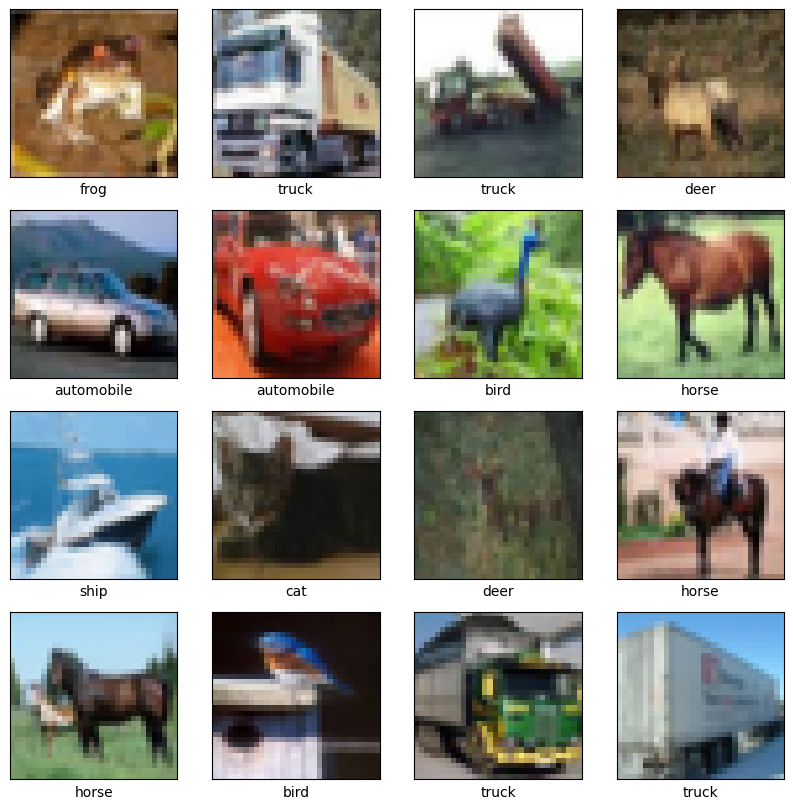

In [ ]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display dataset details
print(f"Training data shape: {train_images.shape}")
print(f"Testing data shape: {test_images.shape}")

# Visualize some images
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

**Reasoning**:
- We begin by importing CIFAR-10 directly from `keras.datasets`, which simplifies the process by avoiding manual downloads [Krizhevsky et al., 2009].
- Visualisation helps understand the dataset and confirm successful loading.

## Step 2: Data Preprocessing and Validation Split

In [ ]:
# Normalize images to scale pixel values between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Split training data to create a validation set (80-20 split)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

print(f"New training data shape: {train_images.shape}")
print(f"Validation data shape: {val_images.shape}")

New training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)


**Reasoning**:
- Normalizing the images accelerates convergence by bringing all pixel values to the [0, 1] range [LeCun et al., 2012].
- A validation set ensures unbiased evaluation during training, mitigating overfitting. A common split ratio is 80-20 for validation [Goodfellow et al., 2016].

## Step 3: Building the CNN Model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3),
                        kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(10, activation='softmax'))

**Reasoning**:
- The architecture leverages convolutional layers to extract spatial hierarchies, essential for image data [Simonyan & Zisserman, 2015].
- MaxPooling reduces dimensions and computational cost, preventing overfitting [Krizhevsky et al., 2012].
- Dense layers finalize classification by mapping extracted features to output classes.

## Step 4: Model Compilation

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Reasoning**:
- Adam optimizer adapts learning rates during training, enhancing convergence [Kingma & Ba, 2014].
- Sparse Categorical Crossentropy suits classification tasks with integer labels, computing efficient loss values.

**Loss Function**:
- Sparse Categorical Crossentropy is used as the loss function because CIFAR-10 is a multi-class classification problem with integer-encoded labels. This function computes the cross-entropy loss between predicted probabilities and ground-truth labels, penalizing incorrect predictions more heavily. Sparse categorical crossentropy is computationally efficient for datasets with discrete class indices, reducing complexity without the need for one-hot encoding [Goodfellow et al., 2016].

## Step 5: Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

**Reasoning**:
- Data augmentation artificially increases the size and diversity of the dataset by applying random transformations, reducing overfitting [Shorten & Khoshgoftaar, 2019].
- Horizontal flipping, shifting, and rotations enhance the network's robustness to image variations.

## Step 6: Model Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
                    epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.3645 - loss: 1.9650 - val_accuracy: 0.1441 - val_loss: 3.3022 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.5700 - loss: 1.2733 - val_accuracy: 0.5426 - val_loss: 1.3693 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.6339 - loss: 1.0982 - val_accuracy: 0.5998 - val_loss: 1.2299 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.6775 - loss: 0.9932 - val_accuracy: 0.5560 - val_loss: 1.3994 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.6904 - loss: 0.9393 - val_accuracy: 0.6143 - val_loss: 1.2471 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.7274 - loss: 0.8527 - val_accuracy: 0.7203 - val_loss: 0.8664 - learning_rate: 5.0000e-04
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.7420

**Reasoning**:
- Training with additional data augmentation slightly differing for each single epoch increases the model’s generalisation capabilities.

## Step 7: Model Evaluation

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=64)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8177 - loss: 0.6042
Test Accuracy: 81.42%
Test Loss: 0.6055


## Step 8: Visualizing Training Results

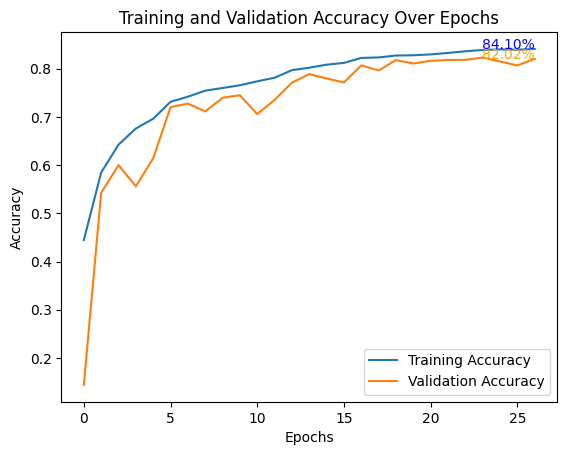

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


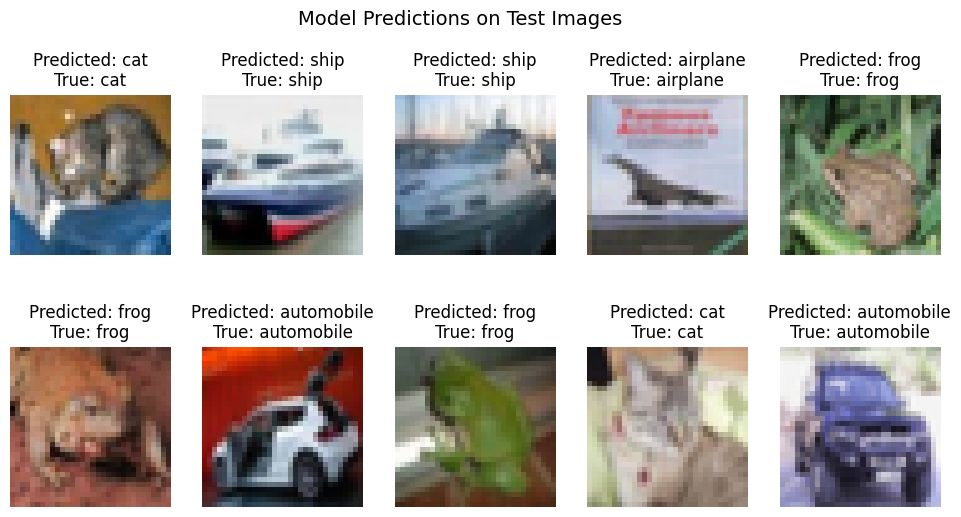

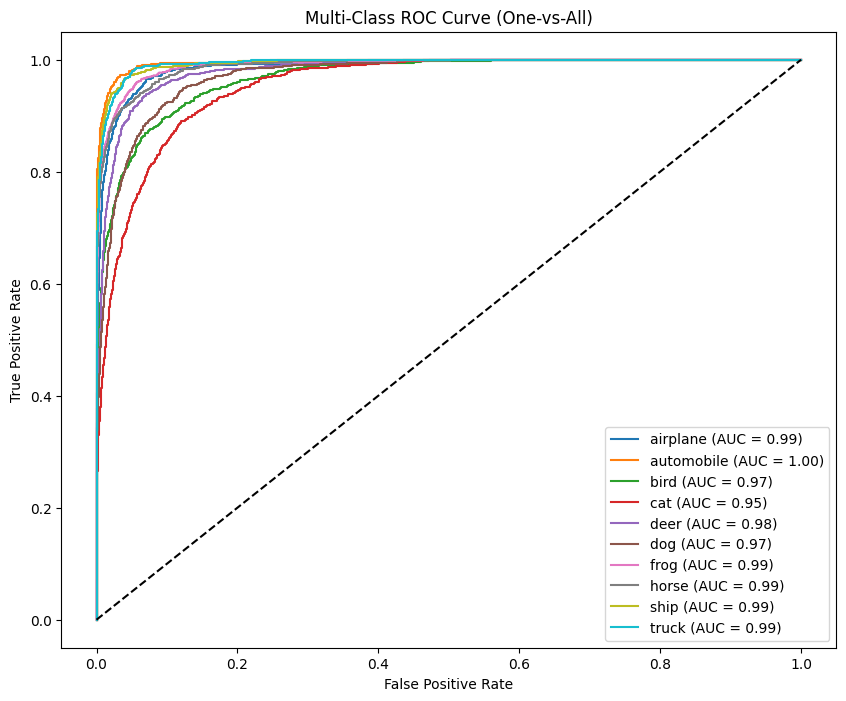

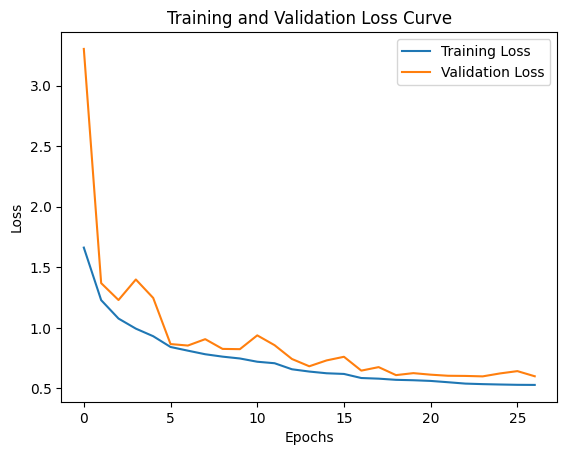

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.85      0.83      1000
  automobile       0.87      0.93      0.90      1000
        bird       0.77      0.72      0.74      1000
         cat       0.73      0.60      0.66      1000
        deer       0.80      0.78      0.79      1000
         dog       0.78      0.69      0.73      1000
        frog       0.77      0.91      0.83      1000
       horse       0.83      0.87      0.85      1000
        ship       0.90      0.89      0.90      1000
       truck       0.86      0.89      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



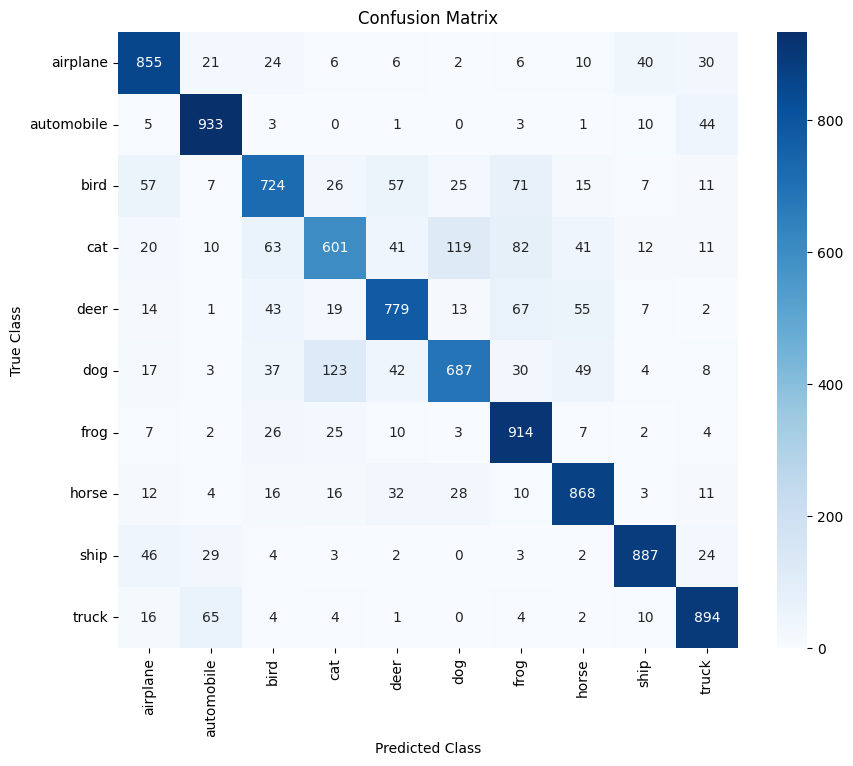

In [ ]:
# Plot accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')  # Add a header
plt.legend()
final_training_acc = history.history['accuracy'][-1] * 100  # Convert to percentage
final_val_acc = history.history['val_accuracy'][-1] * 100  # Convert to percentage
epochs = range(1, len(history.history['accuracy']) + 1)
plt.text(len(epochs) - 1, history.history['accuracy'][-1],
         f"{final_training_acc:.2f}%",
         color='blue', fontsize=10, ha='right')
plt.text(len(epochs) - 1, history.history['val_accuracy'][-1],
         f"{final_val_acc:.2f}%",
         color='orange', fontsize=10, ha='right')
plt.show()

# Make Predictions
predictions = model.predict(test_images)

# Flatten test_labels for the visulisation
true_labels = test_labels.flatten()  # Ensures 1D array of shape (N,)

# Visualize the First 10 Test Images with Predictions
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])  # test_images contains the images
    plt.title(f"Predicted: {class_names[np.argmax(predictions[i])]}\nTrue: {class_names[true_labels[i]]}")
    plt.axis('off')
plt.suptitle('Model Predictions on Test Images', fontsize=14)
plt.show()

# Binarize the labels for multi-class ROC
test_labels_binarized = label_binarize(test_labels, classes=range(10))

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(10):
    fpr, tpr, _ = roc_curve(test_labels_binarized[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Plot the baseline (random classifier)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (One-vs-All)')
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss against the number of epochs
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curve')
plt.show()

# 1. Get Predictions and True Labels
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_true = np.argmax(to_categorical(test_labels, num_classes=10), axis=1)  # True labels

# 2. Classification Report (Precision and Recall for Each Class)
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 4. Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

**Reasoning**:
- The final model is evaluated on test data to estimate generalisation performance.
- Visualisation reveals overfitting or underfitting, aiding hyperparameter tuning.